## Setup Models

In [1]:
from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings
import os

# --- Added to pickup the GitHub token
# From Course Hands-On AI: Introduction to Retrieval-Augmented Generation (RAG) - Yujian Tang
# Repo-file: https://github.com/GabrielECoy/introduction-to-retrieval-augmented-generation-rag-with-hands-on-projects-2023442/blob/main/chapter_1/08_challenge.ipynb
import dotenv
dotenv.load_dotenv()
if not os.getenv("GITHUB_TOKEN"):
    raise ValueError("GITHUB_TOKEN is not set")
#os.environ["OPENAI_API_KEY"] = os.getenv("GITHUB_TOKEN")
#os.environ["OPENAI_BASE_URL"] = "https://models.inference.ai.azure.com/"
# --- Added to pickup the GitHub token

#Setup the environment variables
os.environ["AZURE_OPENAI_API_KEY"]= os.getenv("GITHUB_TOKEN") # "4e4ab31800a64ae892cbb768fe28c0fc"
os.environ["AZURE_OPENAI_ENDPOINT"]="https://models.inference.ai.azure.com/" # "https://agentic-ai-course-kumaran.openai.azure.com/"

#Setup the LLM
model = AzureChatOpenAI(
    azure_deployment="gpt-4o" ,
    api_version="2023-03-15-preview",
    model="gpt-4o"
)

## 06.03. Using agents as Graph nodes

In [2]:
#Reuse the agents created in the previous chapters by importing their notebooks
#This will also import the chatbot and execute the code available.
#Ignore / hide the code output and use only the agents

import time

#import the Product QnA Agent
print("Running no_execution code_03_XX Product QnA Agentic chatbot.ipynb")
print("===============================================================")
%run "no_execution code_03_XX Product QnA Agentic chatbot.ipynb" 
print("===============================================================")
print("===============================================================")
#import the orders agents
print("Running no_execution code_04_XX Orders Chatbot with custom agent.ipynb")
print("===============================================================")
%run "no_execution code_04_XX Orders Chatbot with custom agent.ipynb"
print("===============================================================")
print("===============================================================")


Running no_execution code_03_XX Product QnA Agentic chatbot.ipynb
            Name  Price  ShippingDays
0  AlphaBook Pro   1499             2
1     GammaAir X   1399             7
2  SpectraBook S   2499             7
3   OmegaPro G17   2199            14
4  NanoEdge Flex   1699             2
5     GammaAir Z   2099             7


Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


Running no_execution code_04_XX Orders Chatbot with custom agent.ipynb
   Order ID Product Ordered  Quantity Ordered Delivery Date
0  ORD-8276   SpectraBook S                 3    2024-10-16
1  ORD-6948    OmegaPro G17                 3    2024-10-25
2  ORD-7311   NanoEdge Flex                 2    2024-10-19
3  ORD-4633    OmegaPro G17                 2    2024-10-15
4  ORD-2050      GammaAir X                 2    2024-10-26


In [3]:
import functools
# Helper function to invoke an agent
def agent_node(state, agent, name, config):

    #extract thread-id from request for conversation memory
    thread_id=config["metadata"]["thread_id"]
    #Set the config for calling the agent
    agent_config = {"configurable": {"thread_id": thread_id}}

    #Pass the thread-id to establish memory for chatbot
    #Invoke the agent with the state
    result = agent.invoke(state, agent_config)

    # Convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        final_result=AIMessage(result['messages'][-1].content)
    return {
        "messages": [final_result]
    }

#Create the product QnA node
product_QnA_node=functools.partial(agent_node, 
                                   agent=product_QnA_agent, 
                                   name="Product_QnA_Agent")
#Create the Orders node
#For a custom agent, the agent graph need to be provided as input
orders_node=functools.partial(agent_node,
                              agent=orders_agent.agent_graph,
                              name="Orders_Agent")


## 06.04. Create the Routing Agent & Chatbot

In [4]:
#Creating the routing agent

from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
import operator

class RouterAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

class RouterAgent:

    def __init__(self, model, system_prompt, smalltalk_prompt, debug=False):
        
        self.system_prompt=system_prompt
        self.smalltalk_prompt=smalltalk_prompt
        self.model=model
        self.debug=debug
        
        router_graph=StateGraph(RouterAgentState)
        router_graph.add_node("Router",self.call_llm)
        router_graph.add_node("Product_Agent",product_QnA_node)
        router_graph.add_node("Orders_Agent",orders_node)
        router_graph.add_node("Small_Talk", self.respond_smalltalk)
                              
        router_graph.add_conditional_edges(
            "Router",
            self.find_route,
            {"PRODUCT": "Product_Agent", 
             "ORDER" : "Orders_Agent",
             "SMALLTALK" : "Small_Talk",
             "END": END }
        )

        #One way routing, not coming back to router
        router_graph.add_edge("Product_Agent",END)
        router_graph.add_edge("Orders_Agent",END)
        router_graph.add_edge("Small_Talk",END)
        
        #Set where there graph starts
        router_graph.set_entry_point("Router")
        self.router_graph = router_graph.compile()

    def call_llm(self, state:RouterAgentState):
        messages=state["messages"]
        if self.debug:
            print(f"Call LLM received {messages}")
            
        #If system prompt exists, add to messages in the front
        if self.system_prompt:
            messages = [SystemMessage(content=self.system_prompt)] + messages

        #invoke the model with the message history
        result = self.model.invoke(messages)

        if self.debug:
            print(f"Call LLM result {result}")
        return { "messages":[result] }

    def respond_smalltalk(self, state:RouterAgentState):
        messages=state["messages"]
        if self.debug:
            print(f"Small talk received: {messages}")
            
        #If system prompt exists, add to messages in the front
        
        messages = [SystemMessage(content=self.smalltalk_prompt)] + messages

        #invoke the model with the message history
        result = self.model.invoke(messages)

        if self.debug:
            print(f"Small talk result {result}")
        return { "messages":[result] }
        
    def find_route(self, state:RouterAgentState):
        last_message = state["messages"][-1]
        if self.debug: 
            print("Router: Last result from LLM : ", last_message)

        #Set the last message as the destination
        destination=last_message.content

        if self.debug:
            print(f"Destination chosen : {destination}")
        return destination


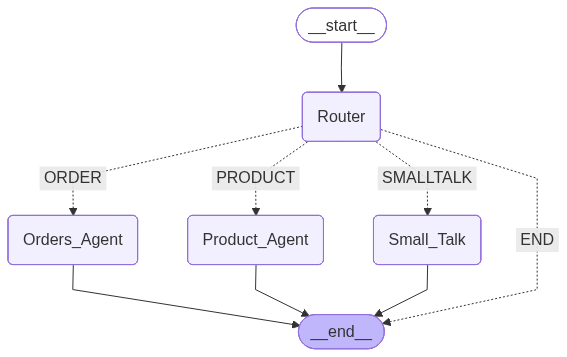

In [8]:
#Create the chatbot
from IPython.display import Image

#Setup the system problem
system_prompt = """ 
You are a Router, that analyzes the input query and chooses 4 options:
SMALLTALK: If the user input is small talk, like greetings and good byes.
PRODUCT: If the query is a product question about laptops, like features, specifications and pricing.
ORDER: If the query is about orders for laptops, like order status, order details or update order quantity
END: Default, when its neither PRODUCT or ORDER.

The output should only be just one word out of the possible 4 : SMALLTALK, PRODUCT, ORDER, END.
"""

smalltalk_prompt="""
If the user request is small talk, like greetings and goodbyes, respond professionally.
Mention that you will be able to answer questions about laptop product features and provide order status and updates.
"""

router_agent = RouterAgent(model, 
                           system_prompt, 
                           smalltalk_prompt,
                           debug=False)

#Visualize the Agent
Image(router_agent.router_graph.get_graph().draw_mermaid_png())

#Visualize the Agent in ascii format
#try:
#    import grandalf.graphs
#except ImportError:
#    %pip install grandalf==0.8
#print(router_agent.router_graph.get_graph().draw_ascii())
##
#                                        +-----------+                                
#                                        | __start__ |                                
#                                        +-----------+                                
#                                              *                                      
#                                              *                                      
#                                              *                                      
#                                         +--------+                                  
#                                      ...| Router |....                              
#                               .......   +--------+.   ......                        
#                         ......        ...          ...      .......                 
#                  .......             .                ..           .......          
#              ....                  ..                   ..                ......    
#+--------------+          +---------------+          +------------+              ....
#| Orders_Agent |**        | Product_Agent |          | Small_Talk |        ......    
#+--------------+  ******* +---------------+          +------------+ .......          
#                         ******        ***          ***      .......                 
#                               *******    *       **   ......                        
#                                      **** **   ** ....                              
#                                        +---------+                                  
#                                        | __end__ |                                  
#                                        +---------+       

In [ ]:
print("===============================================================")
print("Waiting 70 seconds to avoid hitting the rate limit of the Azure OpenAI API...")
time.sleep(70)
print("===============================================================")

## 06.05 Execute the Routing chatbot

In [9]:
#Execute a single request
messages=[HumanMessage(content="Tell me about the features of SpectraBook")]
result=router_agent.router_graph.invoke({"messages":messages},config)
for message in result['messages']:
    print(message.pretty_repr())

Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


================================ Human Message =================================

Tell me about the features of SpectraBook
================================== Ai Message ==================================

PRODUCT
================================== Ai Message ==================================

The **SpectraBook S** is designed for power users. Here are its key features:

- **Processor**: Intel Core i9
- **Memory**: 64GB RAM
- **Storage**: Massive 2TB SSD
- **Purpose**: Ideal for intensive tasks such as video editing and 3D rendering.

It is a workstation-class laptop, ensuring high performance for demanding workloads. Let me know if you'd like to know its price or additional details!


In [10]:
#Execute a single request
messages=[HumanMessage(content="What is the status of order ORD-7311?")]
result=router_agent.router_graph.invoke({"messages":messages},config)
for message in result['messages']:
    print(message.pretty_repr())

================================ Human Message =================================

What is the status of order ORD-7311?
================================== Ai Message ==================================

ORDER
================================== Ai Message ==================================

The details for order **ORD-7311** are as follows:

- **Product Ordered**: NanoEdge Flex  
- **Quantity Ordered**: 2  
- **Delivery Date**: 2024-10-19  

Let me know if you need any further assistance with this order!


In [11]:
import uuid
#Send a sequence of messages to chatbot and get its response
#This simulates the conversation between the user and the Agentic chatbot
user_inputs = [
    "How are you doing?",
    "Please show me the details of the order ORD-7311",
    "Can you add one more of that laptop to the order? ",
    "Tell me about the features of SpectraBook laptop",
    "How much does it cost?",
    "Bye"
]

#Create a new thread
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

for input in user_inputs:
    print(f"----------------------------------------\nUSER : {input}")
    #Format the user message
    user_message = {"messages":[HumanMessage(input)]}
    #Get response from the agent
    ai_response = router_agent.router_graph.invoke(user_message,config=config)
    #Print the response
    print(f"\nAGENT : {ai_response['messages'][-2].content}")
    print(f"\nAGENT : {ai_response['messages'][-1].content}")


----------------------------------------
USER : How are you doing?

AGENT : SMALLTALK

AGENT : Hello! I'm doing well, thank you for asking. How can I assist you today? If you have questions about laptop product features or need updates on an order, feel free to let me know!
----------------------------------------
USER : Please show me the details of the order ORD-7311

AGENT : ORDER

AGENT : Here are the details for order **ORD-7311**:

- **Product Ordered**: NanoEdge Flex
- **Quantity Ordered**: 2
- **Delivery Date**: October 19, 2024
----------------------------------------
USER : Can you add one more of that laptop to the order? 

AGENT : ORDER

AGENT : The order **ORD-7311** has been successfully updated to include 3 units of the NanoEdge Flex laptop. Let me know if you need further assistance!
----------------------------------------
USER : Tell me about the features of SpectraBook laptop

AGENT : PRODUCT

AGENT : The **SpectraBook S** is designed for power users and offers impre